In [30]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
# accuracy, precision, recall, f1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
# load datasetp
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Test model performance before Hyperparameter searching

from sklearn.svm import SVC

svc = SVC(class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Before hyperparameter searching")
print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Before hyperparameter searching
Accuracy: 0.8655367231638418
Recall: 0.7974683544303798
Precision: 0.8208469055374593
F1 score: 0.8089887640449438


In [32]:
# hyperparameter search for SVM
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')
param_grid = {'C': [1, 10, 100, 200, 500, 1000], 
              'gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 
              'kernel': ['rbf', 'sigmoid', 'poly']}
# scoring on both accuracy and recall
grid = GridSearchCV(svc, param_grid, refit=True, scoring='roc_auc', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
gscore = grid.score(X_train, y_train)
print("score for gridsearch", gscore)

# Test model performance after Hyperparameter searching
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Recall:', recall)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 200, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=200, class_weight='balanced', gamma=0.0001)
score for gridsearch 0.9312834393601952
Accuracy: 0.8497175141242937
Recall: 0.8132911392405063


Threshold: 0.08 Recall: 0.8894 Accuracy: 0.7232
Threshold: 0.09 Recall: 0.8850 Accuracy: 0.7415
Threshold: 0.10 Recall: 0.8805 Accuracy: 0.7585
Threshold: 0.11 Recall: 0.8761 Accuracy: 0.7768
Threshold: 0.12 Recall: 0.8628 Accuracy: 0.7853
Threshold: 0.13 Recall: 0.8584 Accuracy: 0.7980
Threshold: 0.14 Recall: 0.8496 Accuracy: 0.8065
Threshold: 0.15 Recall: 0.8451 Accuracy: 0.8093
Threshold: 0.16 Recall: 0.8407 Accuracy: 0.8164
Threshold: 0.17 Recall: 0.8319 Accuracy: 0.8192
Threshold: 0.18 Recall: 0.8274 Accuracy: 0.8220
Threshold: 0.19 Recall: 0.8186 Accuracy: 0.8305
Threshold: 0.20 Recall: 0.8186 Accuracy: 0.8390
Threshold: 0.21 Recall: 0.8186 Accuracy: 0.8404
Threshold: 0.22 Recall: 0.8186 Accuracy: 0.8460
Threshold: 0.23 Recall: 0.8142 Accuracy: 0.8517
Threshold: 0.24 Recall: 0.8142 Accuracy: 0.8573
Threshold: 0.25 Recall: 0.8142 Accuracy: 0.8630
Threshold: 0.26 Recall: 0.8142 Accuracy: 0.8644
Threshold: 0.27 Recall: 0.8142 Accuracy: 0.8658
Threshold: 0.28 Recall: 0.8142 Accuracy:

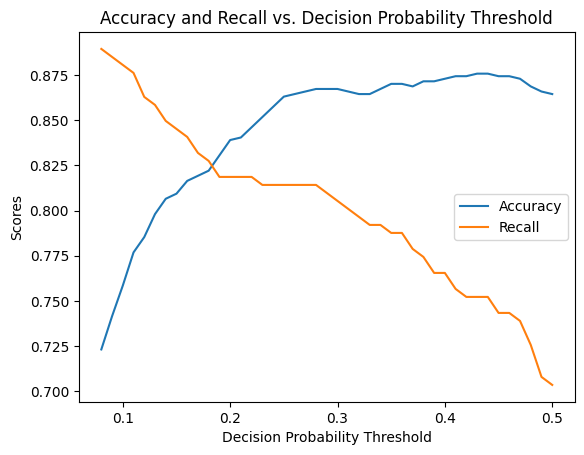

In [33]:
# hyper parameter search for decision threshold

# split traning set into training and validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

classifier = SVC(kernel='rbf', gamma=0.0001, C=200, random_state=42, class_weight='balanced', probability=True)
classifier.fit(X_train_sub, y_train_sub)
y_pred_prob = classifier.predict_proba(X_val)[:, 1]
# hyperparameter search for SVM
accuracys = []
recalls = []
for threshold in np.arange(0.08, 0.51, 0.01):
    y_pred = y_pred_prob > threshold
    # format and print threshold with .2f
    print('Threshold: {:.2f} Recall: {:.4f} Accuracy: {:.4f}'.format(threshold, recall_score(y_val, y_pred), accuracy_score(y_val, y_pred)))

    accuracys.append(accuracy_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

plt.plot(np.arange(0.08, 0.51, 0.01), accuracys, label='Accuracy') 
plt.plot(np.arange(0.08, 0.51, 0.01), recalls, label='Recall')
plt.xlabel('Decision Probability Threshold')
plt.ylabel('Scores')
plt.title('Accuracy and Recall vs. Decision Probability Threshold')
plt.legend()
plt.show()

In [34]:
# use cross validation to evaluate model consistency on X_train data
from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma=0.0001, C=200, random_state=42, class_weight='balanced')
scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='recall')
print("recall mean:", scores.mean(), "recall std:", scores.std())

scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

recall mean: 0.8270843570843571 recall std: 0.029114529934501053
accuracy mean: 0.8705822570061299 accuracy std: 0.011317278521159815


After using model parameter without threshold tuning
Recall: 0.8132911392405063
Accuracy: 0.8497175141242937
Precision: 0.7764350453172205
F1 Score: 0.794435857805255


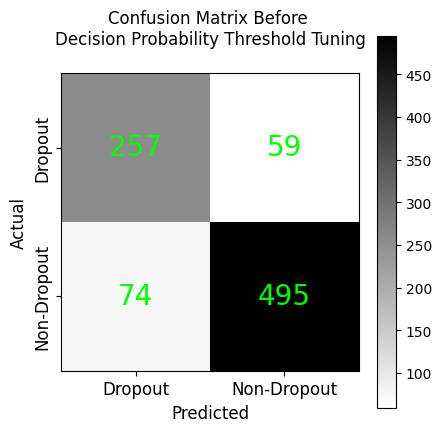

'\n# count 1 and 0 in y_test\nprint(y_test.value_counts())\n# count 1 and 0 in y_pred\nprint(pd.Series(y_pred).value_counts())\n'

In [35]:
# classification with kernel svm, without using the threshold hyperparameter

from sklearn.metrics import confusion_matrix

classifier = SVC(kernel='rbf', gamma=0.0001, C=200, random_state=42, class_weight='balanced', probability=True)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_test_proba = classifier.predict_proba(X_test)[:, 1]
print("After using model parameter without threshold tuning")
print('Recall:', recall_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Before \nDecision Probability Threshold Tuning\n')
# change origin to top left
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xticks([0, 1], ['Non-Dropout', 'Dropout'])
plt.yticks([0, 1], ['Non-Dropout', 'Dropout'])
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelrotation=90, labelsize=12)
for label in plt.gca().get_yticklabels():
    label.set_verticalalignment('center')

# x ticks at bottom
plt.gca().xaxis.tick_bottom()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='lime', fontsize=20)
plt.show()

'''
# count 1 and 0 in y_test
print(y_test.value_counts())
# count 1 and 0 in y_pred
print(pd.Series(y_pred).value_counts())
'''

After using model parameter with threshold tuning
Recall: 0.9177215189873418
Accuracy: 0.7853107344632768
Precision: 0.6387665198237885
F1 Score: 0.7532467532467533


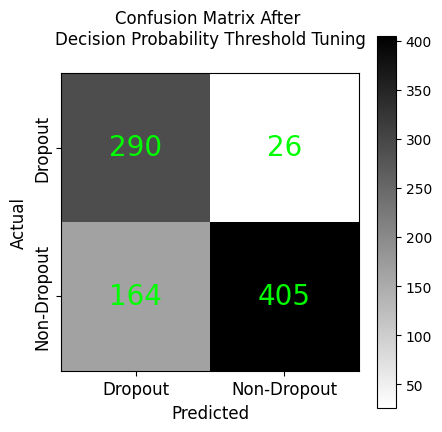

'\n# count 1 and 0 in y_test\nprint(y_test.value_counts())\n# count 1 and 0 in y_pred\nprint(pd.Series(y_pred).value_counts())\n'

In [36]:
# I can also increase recall by lowering the decision threshold
decision_threshold = 0.12
y_pred = y_test_proba > decision_threshold
print("After using model parameter with threshold tuning")
print('Recall:', recall_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.binary)
plt.colorbar()

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix After \nDecision Probability Threshold Tuning\n')
# change origin to top left
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xticks([0, 1], ['Non-Dropout', 'Dropout'])
plt.yticks([0, 1], ['Non-Dropout', 'Dropout'])
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelrotation=90, labelsize=12)
for label in plt.gca().get_yticklabels():
    label.set_verticalalignment('center')

# x ticks at bottom
plt.gca().xaxis.tick_bottom()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='lime', fontsize=20)
plt.show()

'''
# count 1 and 0 in y_test
print(y_test.value_counts())
# count 1 and 0 in y_pred
print(pd.Series(y_pred).value_counts())
'''

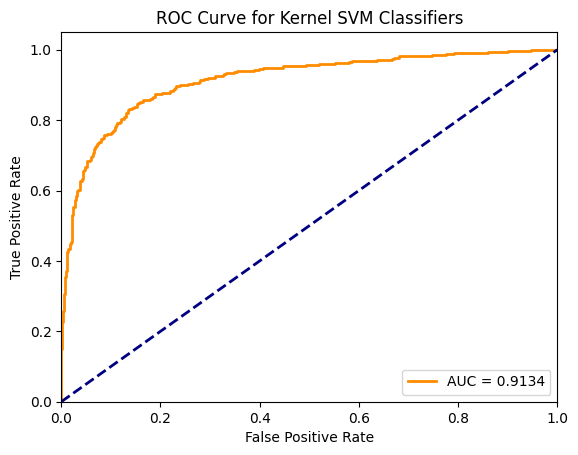

In [37]:
# roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
# auc
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for Kernel SVM Classifiers')
plt.legend(loc="lower right")
plt.show()
